# Policy Gradients
### Introduction
On this notebook we will train a policy network to solve a particular problem on the OpenAI Environment. We will train this policy network with the REINFORCE algorithm.
![alt text](imgs/policy_stochastic.png "Game")

#### REINFORCE Algorithm
#### Short Introduction
The REINFORCE algorithm is one implementation of the Policy Gradient family of algorithms, the idea of the algorithm is to have the policy represented by a neural network with $\theta$ parameters. The main idea of the algorithm is to change the network parameters to make the actions that provided positive rewards to be more probable to happen. The training phase optimize the following loss function:
$$\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$$
Where:
* $\hat{Q}(s,a)$: It's an estimate of the state action function, that will modulate the probability of good actions to happen more often.
* $\pi_{\theta}(a|s)$: It's the neural network that represent the policy and returns an distribution of actions given an state.

The steps of the algorithm
1. Initialize Network at random
2. Play N episodes saving their transitions "k" (s,a,r,s')
3. For every episode calculate $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
4. Perform SGD to minimize the loss: $\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$
5. Repeat 2 until convergence 

#### Disadvantages of Policy Gradients
* Full episodes are required, we need to wait a full episode to complete
* High Gradients Variance: This issue can be handled by subtracting a baseline from the Value estimation
* Exploration: The agent can converge to a local-optimal area and won't explore efficiently anymore. This can be solved by the Entropy Bonus technique that basically subtract the entropy of the policy from the loss function.
* Correlation between samples: This can be remedy by using parallel environments with same policy and using the experiences from different environments to train the policy.
* Less sample efficient: To deal with this we need another algorithm (Actor-Critic)

The image bellow can highlight the full episodic issue, where we have 2 trajectories where one or more actions could be bad, but as the final total score is good those bad actions will be averaged. That's one of the reasons why Policy Gradient methods are less sample efficient.
![alt text](imgs/episode_problem.png "Game")

#### Cartpole Rules
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* http://karpathy.github.io/2016/05/31/rl/
* https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf
* https://leimao.github.io/article/REINFORCE-Policy-Gradient/
* https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c
* https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f
* https://gist.github.com/tamlyn/a9d2b3990f9dab0f82d1dfc1588c876a
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
* https://www.youtube.com/watch?v=iOh7QUZGyiU&list=PLqYmG7hTraZDNJre23vqCGIVpfZ_K2RZs
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html
* https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6
* https://towardsdatascience.com/learning-to-drive-smoothly-in-minutes-450a7cdb35f4
* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf
* https://fosterelli.co/entropy-loss-for-reinforcement-learning
* https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296

### Import Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

### Initialize Environment and Hyper parameters

In [2]:
env = gym.make('CartPole-v1')
# Uncomment for this environment (takes longer to train)
#env = gym.make('LunarLander-v2')

# Hyperparameters
learning_rate = 0.01
entropy_beta = 0.01
gamma = 0.99
num_episodes=1500

# Show some information from the environment
print('Amount of rewards consider as win:', env.spec.reward_threshold)
print('Action space:', env.action_space.n)
print('Observation space:', env.observation_space.shape)
print('Reward range:', env.reward_range)

Amount of rewards consider as win: 475.0
Action space: 2
Observation space: (4,)
Reward range: (-inf, inf)


### Fix Random Seeds
To make the experiment reproducible, we will fix the following random seeds:
* OpenAI Gym
* Numpy
* Tensorflow

In [3]:
env.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### Policy Network
Define the policy Neural Network, which inputs will be the state and output an action

In [53]:
class Policy(Model):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.FC1 = Dense(num_hidden, activation='relu', input_dim=state_space, use_bias=False)
        self.DP1 = Dropout(rate=0.5)
        self.FC2 = Dense(action_space, activation='softmax', use_bias=False)

        # Overall reward and loss history (Just for plotting training information)
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy log probability(action) and reward history
        self.episode_log_prob_actions = None
        self.episode_log_prob_actions_dist = None
        self.episode_prob_actions = None
        self.episode_rewards = []

    def call(self, x, keep_history=False):
        # Convert state to tensor
        # inputs is a numpy array, convert to Tensor
        x = np.expand_dims(x, axis=0)        
        x = tf.convert_to_tensor(x, dtype=tf.float64)          
        x = self.FC1(x)
        x = self.DP1(x)
        action_probs = self.FC2(x)        
        
        # Execute model and sample it's outputs        
        action = tf.squeeze(tf.random.categorical(action_probs,1), axis=-1)        
        
        #print('action_probs:', action_probs.size())
        #print('distribution.log_prob:', distribution.log_prob(action).size())
        #print('F.log_prob(action_probs):', torch.log(action_probs).size())
        
        # Concatenate log probability of the action to be used on the loss function
        if keep_history:                        
            # Concatenate the log of the choosen action
            if self.episode_log_prob_actions is None:                
                self.episode_log_prob_actions = [tf.math.log(action_probs[0][action[0]])]                               
            else:                
                self.episode_log_prob_actions = tf.concat([self.episode_log_prob_actions, 
                                                           [tf.math.log(action_probs[0][action[0]])]], axis=0)
            
            # Concatenate the log the action distribution
            if self.episode_log_prob_actions_dist is None:
                self.episode_log_prob_actions_dist = tf.math.log(action_probs)
            else:
                self.episode_log_prob_actions_dist = tf.concat([self.episode_log_prob_actions_dist, 
                                                                tf.math.log(action_probs)], axis=0)
            # Concatenate the action distribution
            if self.episode_prob_actions is None:
                self.episode_prob_actions = action_probs
            else:
                self.episode_prob_actions = tf.concat([self.episode_prob_actions, action_probs], axis=0)
        
        return  tf.squeeze(action, axis=-1).numpy()

In [54]:
policy = Policy()
optimizer= tf.keras.optimizers.Adam(lr=learning_rate)

### Define the update policy function
This function is called after we gather a complete episode, and it does the following tasks:
1. Calculate the discounted Rewards: $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
2. Calculate the baseline (rewards mean) and normalize the discounted rewards
3. Calculate the entropy loss (Optional)
4. Calculate the Policy loss
5. Calculate the complete loss
6. Do the loss backpropagation (Pytorch)

In [55]:
#@tf.function
def update_policy(use_baseline = False, use_entropy = False):
    R = 0
    rewards = []

    # Discount future rewards starting from the most recent reward backwards
    for r in reversed(policy.episode_rewards):
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards to make the advantage be 1/-1 (Zero-mean Unit variance)
    # This is one of multiple ways to implement the advantage, for example if you use another network
    # to learn the advantage this will become the actor-critic algorithm.
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float64)
    
    if use_baseline:
        baseline = tf.math.reduce_mean(rewards)
        # Calculate the value estimation with a baseline (Without the baseline will be harder to converge)
        Q_estim = (rewards - baseline) / (rewards.std() + np.finfo(np.float32).eps)
    else:
        Q_estim = rewards

    # Calculate the entropy 
    entropy_loss = -entropy_beta * (tf.math.reduce_sum(
        policy.episode_prob_actions * policy.episode_log_prob_actions_dist))
    
    # Calculate the policy loss    
    police_loss = tf.math.reduce_sum(-Q_estim * policy.episode_log_prob_actions)
    
    if use_entropy:
        # Calculate loss log_prob(action) * rewards
        loss = police_loss - entropy_loss    
    else:
        loss = police_loss
    
    # Save and intialize episode history counters
    policy.loss_history.append(loss)
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()
    return loss

### Check untrained Policy

In [56]:
state = env.reset()

for time in range(50):
    # Get an action from the Policy
    action = policy(state)

    # Render screen
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    

### Train on the Environment

In [57]:
%%time
length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()
    
    # Record operations for automatic-differentiation
    with tf.GradientTape() as tape:
        for time in range(1000):
            # Get an action from the Policy and keep the historical data
            action = policy(state, keep_history=True)

            # Step through environment using chosen action
            state, reward, done, _ = env.step(action)

            # Save reward
            policy.episode_rewards.append(reward)
            rewards_episode.append(reward)
            if done:
                break

        # Calculate score to determine when the environment has been solved
        length_episode.append(time)
        mean_length_episode = np.mean(length_episode[-100:])
        mean_rewards_episode = np.mean(rewards_episode)
        
        # Calculate the discounted rewards on the episode, calculate loss and backpropagate
        loss = update_policy()
        
    # Calculate the gradient of the loss with respect to the model parameters
    gradients = tape.gradient(loss, policy.trainable_variables)
    # Run optimizer
    optimizer.apply_gradients(zip(gradients, policy.trainable_variables))

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 9.00 Average Rewards 1.00
Episode 50	Average length (last 100 episodes): 24.67 Average Rewards 1.00
Episode 100	Average length (last 100 episodes): 27.07 Average Rewards 1.00
Episode 150	Average length (last 100 episodes): 29.50 Average Rewards 1.00
Episode 200	Average length (last 100 episodes): 30.11 Average Rewards 1.00
Episode 250	Average length (last 100 episodes): 31.37 Average Rewards 1.00
Episode 300	Average length (last 100 episodes): 29.87 Average Rewards 1.00
Episode 350	Average length (last 100 episodes): 28.80 Average Rewards 1.00
Episode 400	Average length (last 100 episodes): 30.86 Average Rewards 1.00
Episode 450	Average length (last 100 episodes): 31.03 Average Rewards 1.00
Episode 500	Average length (last 100 episodes): 26.34 Average Rewards 1.00
Episode 550	Average length (last 100 episodes): 30.02 Average Rewards 1.00
Episode 600	Average length (last 100 episodes): 38.19 Average Rewards 1.00
Episode 650	Average length (l

### Plot Training information

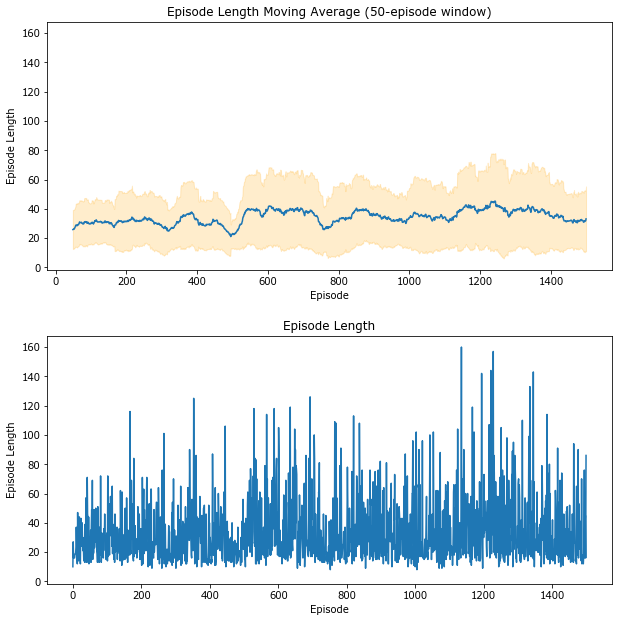

In [58]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()


### Test the Trained Policy

In [62]:
state = env.reset()

for time in range(1000):
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break

### Improving sample efficiency
Policy Gradient algorithms are already sample-efficiency worse than value based algorithms. Calculating a baseline and subtracting from your value estimate $\hat{Q}$ will improve sample efficiency. Here is a list of poossible choices for baselines:
* Some constant value, for example the mean of the discounted rewards
* Moving average of discounted rewards
* Value of state V(s)
Also depending if we use anohter network to learn out baseline we will be working on the Actor-Critic family o algorithms.

In [63]:
%%time
length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()
    
    # Record operations for automatic-differentiation
    with tf.GradientTape() as tape:
        for time in range(1000):
            # Get an action from the Policy and keep the historical data
            action = policy(state, keep_history=True)

            # Step through environment using chosen action
            state, reward, done, _ = env.step(action)

            # Save reward
            policy.episode_rewards.append(reward)
            rewards_episode.append(reward)
            if done:
                break

        # Calculate score to determine when the environment has been solved
        length_episode.append(time)
        mean_length_episode = np.mean(length_episode[-100:])
        mean_rewards_episode = np.mean(rewards_episode)
        
        # Calculate the discounted rewards on the episode, calculate loss and backpropagate
        loss = update_policy(use_baseline=True)
        
    # Calculate the gradient of the loss with respect to the model parameters
    gradients = tape.gradient(loss, policy.trainable_variables)
    # Run optimizer
    optimizer.apply_gradients(zip(gradients, policy.trainable_variables))

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'std'

In [ ]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Improving Exploration/Exploitation
In order to avoid the policy to conferge fast and stop exploring (Get stuck in local minima) in the environment, there is a trick called entropy bonus.
$$H(\pi)=-\sum{\pi_{\theta}(a|s).log\pi_{\theta}(a|s)}$$
This will simply show how much uncertain the policy is about it's actions. 
We just need to subtract the entropy bons from the loss function, forcing the policy to take more time to be certain and exploring more.

In [ ]:
%%time
length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()
    
    # Record operations for automatic-differentiation
    with tf.GradientTape() as tape:
        for time in range(1000):
            # Get an action from the Policy and keep the historical data
            action = policy(state, keep_history=True)

            # Step through environment using chosen action
            state, reward, done, _ = env.step(action)

            # Save reward
            policy.episode_rewards.append(reward)
            rewards_episode.append(reward)
            if done:
                break

        # Calculate score to determine when the environment has been solved
        length_episode.append(time)
        mean_length_episode = np.mean(length_episode[-100:])
        mean_rewards_episode = np.mean(rewards_episode)
        
        # Calculate the discounted rewards on the episode, calculate loss and backpropagate
        loss = update_policy(use_baseline=True, use_entropy=True)
        
    # Calculate the gradient of the loss with respect to the model parameters
    gradients = tape.gradient(loss, policy.trainable_variables)
    # Run optimizer
    optimizer.apply_gradients(zip(gradients, policy.trainable_variables))

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

In [ ]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

In [ ]:
state = env.reset()

while True:
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break

In [ ]:
tf.math.reduce_sum([1,2,3])